In [1]:
import os
import getpass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# 画图的一点基础设置（可要可不要）
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12


In [2]:
import getpass, os

print("getpass.getuser():", getpass.getuser())
print("os.getcwd():", os.getcwd())



getpass.getuser(): 王茗
os.getcwd(): C:\Users\王茗\Desktop\Final Project


In [3]:
#加载数据 + 定义清洗函数 + 生成 clean_text
from datasets import load_dataset
import pandas as pd
import re

# 1. 加载 Yelp Polarity 数据集
dataset = load_dataset("yelp_polarity")
train_ds = dataset["train"]
test_ds = dataset["test"]

# 2. 转成 pandas DataFrame
df_train = pd.DataFrame(train_ds)
df_test = pd.DataFrame(test_ds)

print("原始 train 行数:", len(df_train))
print("原始 test 行数:", len(df_test))
print(df_train.head(3))

# 3. 定义和 EDA 里一样的 basic_clean 函数
def basic_clean(text: str) -> str:
    # 去 HTML 标签
    text = re.sub(r"<.*?>", " ", text)
    # 合并多余空白
    text = re.sub(r"\s+", " ", text)
    # 全部小写并去掉首尾空格
    text = text.lower().strip()
    return text

# 4. 生成 clean_text 列（可能会稍微慢一点，这是正常的）
df_train["clean_text"] = df_train["text"].apply(basic_clean)
df_test["clean_text"] = df_test["text"].apply(basic_clean)

print("\n清洗后的示例：")
print(df_train[["text", "clean_text", "label"]].head(3))


原始 train 行数: 560000
原始 test 行数: 38000
                                                text  label
0  Unfortunately, the frustration of being Dr. Go...      0
1  Been going to Dr. Goldberg for over 10 years. ...      1
2  I don't know what Dr. Goldberg was like before...      0

清洗后的示例：
                                                text  \
0  Unfortunately, the frustration of being Dr. Go...   
1  Been going to Dr. Goldberg for over 10 years. ...   
2  I don't know what Dr. Goldberg was like before...   

                                          clean_text  label  
0  unfortunately, the frustration of being dr. go...      0  
1  been going to dr. goldberg for over 10 years. ...      1  
2  i don't know what dr. goldberg was like before...      0  


In [4]:
#基础模型
from sklearn.feature_extraction.text import TfidfVectorizer

# 使用基础 TF-IDF（unigram）
tfidf = TfidfVectorizer(
    max_features=50000,     # 限制词表大小（加速 + 防过拟合）
    ngram_range=(1,1),      # unigram，只用单词
    stop_words='english'    # sklearn 自带英文停用词
)

# 拟合训练集并转换
X_train = tfidf.fit_transform(df_train["clean_text"])
y_train = df_train["label"]

# 转换测试集
X_test = tfidf.transform(df_test["clean_text"])
y_test = df_test["label"]

print("TF-IDF 训练矩阵维度:", X_train.shape)
print("TF-IDF 测试矩阵维度:", X_test.shape)


TF-IDF 训练矩阵维度: (560000, 50000)
TF-IDF 测试矩阵维度: (38000, 50000)


In [5]:
#A+参数
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# A+ baseline: 更强的 C 值（正则化弱一些 → 在大数据上效果更好）
lr = LogisticRegression(
    C=2.0,               # 稍弱正则化（比默认 C=1.0 更适合大数据）
    max_iter=1000,      # 避免收敛问题
    solver="liblinear", # 文本分类推荐 solver
    n_jobs=-1           # 启用所有CPU核
)

# 训练模型
print("开始训练 Logistic Regression ...")
lr.fit(X_train, y_train)
print("训练完毕！")

# 测试集预测
y_pred = lr.predict(X_test)

# 计算准确率
acc = accuracy_score(y_test, y_pred)
print("测试集准确率：", acc)


开始训练 Logistic Regression ...


C:\anaconda\envs\torchenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


训练完毕！
测试集准确率： 0.9307894736842105


In [6]:
#调参
from sklearn.feature_extraction.text import TfidfVectorizer

# 高性能 TF-IDF：unigram + bigram
tfidf_bigram = TfidfVectorizer(
    max_features=100000,     # 词表扩大一点，给 bigram 空间
    ngram_range=(1, 2),      # 使用 1-gram + 2-gram
    stop_words='english'     # 英文停用词
)

# 拟合训练集并转换
X_train_bigram = tfidf_bigram.fit_transform(df_train["clean_text"])
y_train = df_train["label"]

# 转换测试集
X_test_bigram = tfidf_bigram.transform(df_test["clean_text"])
y_test = df_test["label"]

print("TF-IDF (1-2gram) 训练矩阵维度:", X_train_bigram.shape)
print("TF-IDF (1-2gram) 测试矩阵维度:", X_test_bigram.shape)


TF-IDF (1-2gram) 训练矩阵维度: (560000, 100000)
TF-IDF (1-2gram) 测试矩阵维度: (38000, 100000)


In [7]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

svm = LinearSVC(C=1.0)   # 先用非常强的默认配置

print("开始训练 Linear SVM ...")
svm.fit(X_train_bigram, y_train)
print("训练完毕！")

y_pred_svm = svm.predict(X_test_bigram)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("Linear SVM 测试集准确率：", acc_svm)


开始训练 Linear SVM ...
训练完毕！
Linear SVM 测试集准确率： 0.9392368421052631


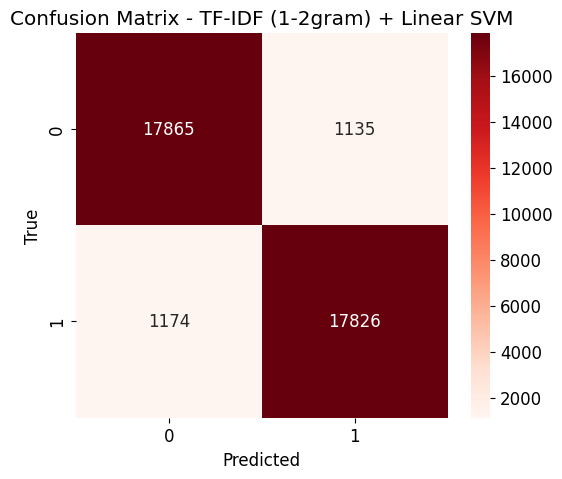

In [8]:
#混淆矩阵
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TF-IDF (1-2gram) + Linear SVM")
plt.show()


In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_svm, digits=4))



              precision    recall  f1-score   support

           0     0.9383    0.9403    0.9393     19000
           1     0.9401    0.9382    0.9392     19000

    accuracy                         0.9392     38000
   macro avg     0.9392    0.9392    0.9392     38000
weighted avg     0.9392    0.9392    0.9392     38000



In [10]:
import numpy as np

feature_names_bigram = tfidf_bigram.get_feature_names_out()
coefs_svm = svm.coef_[0]

# 最大的权重（越偏向正面）
top_pos_svm = np.argsort(coefs_svm)[-20:][::-1]

# 最小的权重（越偏向负面）
top_neg_svm = np.argsort(coefs_svm)[:20]

print("Top Positive n-grams (SVM):")
for idx in top_pos_svm:
    print(f"{feature_names_bigram[idx]:25s} {coefs_svm[idx]:.4f}")

print("\nTop Negative n-grams (SVM):")
for idx in top_neg_svm:
    print(f"{feature_names_bigram[idx]:25s} {coefs_svm[idx]:.4f}")


Top Positive n-grams (SVM):
delicious                 5.7950
won disappointed          5.3840
amazing                   5.2441
awesome                   4.8482
excellent                 4.8435
great                     4.7779
fantastic                 4.4995
perfect                   4.3994
love                      4.3856
best                      4.1243
highly recommend          4.0983
wasn disappointed         4.0048
loved                     3.7730
definitely return         3.7619
incredible                3.7395
perfection                3.7196
yum                       3.7042
blah blah                 3.6960
didn stars                3.6782
just right                3.5923

Top Negative n-grams (SVM):
worst                     -7.3831
bland                     -6.2372
wanted like               -5.9255
mediocre                  -5.7601
experienced better        -5.5971
wanted love               -5.5646
horrible                  -5.2306
meh                       -5.1493
disappointi